<a href="https://colab.research.google.com/github/FLC-ML/raman-id/blob/swimmer-patch-1/Keras_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras API ResNet
Much of the code for this project came from: https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

# Load Data

The most direct way to download data is from the URL. Use `!wget` to download the files. For this Dropbox URL, make sure to change the "0" at the end to a "1" to force the download.

In [17]:
# Training Data
!wget https://www.dropbox.com/sh/gmgduvzyl5tken6/AAD6E17hrD8CfKwmRB9wfTKqa/X_reference.npy
!wget https://www.dropbox.com/sh/gmgduvzyl5tken6/AACaXFPq1qA5kLvhIF0Y0NfEa/y_reference.npy
# Testing Data
!wget https://www.dropbox.com/sh/gmgduvzyl5tken6/AABKsseO9QvObI4lTt-yXg8ta/X_test.npy
!wget https://www.dropbox.com/sh/gmgduvzyl5tken6/AACitgFQG5cfd7qs--swRbI0a/y_test.npy
# Finetuning Data
!wget https://www.dropbox.com/sh/gmgduvzyl5tken6/AABCIPeDRGQtP5VkFjBUutp1a/X_finetune.npy
!wget https://www.dropbox.com/sh/gmgduvzyl5tken6/AABVIHDlXiz20y-q2wmdCKgsa/y_finetune.npy

--2020-07-21 17:46:18--  https://www.dropbox.com/sh/gmgduvzyl5tken6/AAD6E17hrD8CfKwmRB9wfTKqa/X_reference.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/gmgduvzyl5tken6/AAD6E17hrD8CfKwmRB9wfTKqa/X_reference.npy [following]
--2020-07-21 17:46:19--  https://www.dropbox.com/sh/raw/gmgduvzyl5tken6/AAD6E17hrD8CfKwmRB9wfTKqa/X_reference.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc53d729fc3de4af8abdef314c06.dl.dropboxusercontent.com/cd/0/inline/A79aeQpegO3pJRQGgwa3p3TgrN_CEpmC1dUy9JLc-NGNdw8qvYMIJSdWoPmbeMHl8Y4tQ23oPkKdQK0dSevyLSWQvt6C4MUa-CWuy9no1p-lzRxBIsTmaMj1LfrND5Swo9I/file# [following]
--2020-07-21 17:46:19--  https://uc53d729fc3de4af8abdef314c06.dl.dropboxusercontent.com/cd/0/inline/A79aeQpegO3pJRQGgwa3p

# Import Libraries

Adding in functions from libraries also makes the code easier to read. Tensorflow and Numpy are the main libraries. Matplotlib is used for data visualization, as well as sklearn for the confusion matrix.

In [18]:
# Libraries
import os

import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv1D, ReLU, BatchNormalization,\
                                    Add, AveragePooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
# Learn how to use this callback.
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import confusion_matrix
import itertools

import numpy as np
import matplotlib.pyplot as plt # Use pip install to get this outside of notebook
from matplotlib import cm

In [19]:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5)

# Load the data

Load the reference and test data into Numpy arrays. You will need to also reshape the data to feed into the model. Number of shapes needs to be 3.

In [20]:
# Training Data Load
X_train_loc = 'X_reference.npy'
y_train_loc = 'y_reference.npy'
X_train = np.load(X_train_loc)
y_train = np.load(y_train_loc)

# Testing data
X_test_loc = 'X_test.npy'
y_test_loc = 'y_test.npy'
X_test = np.load(X_test_loc)
y_test = np.load(y_test_loc)

# Finetuning data
X_finetune_loc = 'X_finetune.npy'
y_finetune_loc = 'y_finetune.npy'
X_finetune = np.load(X_finetune_loc)
y_finetune = np.load(y_finetune_loc)

Reshape the data with the code below.

In [21]:
# The data is only 2D in shape.
X_train = np.expand_dims(X_train, -1) 
X_test = np.expand_dims(X_test, -1)
X_finetune = np.expand_dims(X_finetune, -1)
print("\nnew x_train shape:", X_train.shape)
print("new x_test shape:", X_test.shape)
print("new x_finetune shape:", X_finetune.shape)
print("\nAll X data index shape:", X_train[0].shape)



new x_train shape: (60000, 1000, 1)
new x_test shape: (3000, 1000, 1)
new x_finetune shape: (3000, 1000, 1)

All X data index shape: (1000, 1)


Showing the final shape of the loaded data.

In [22]:
# Print shape of data loaded.
print("training set shape:", X_train.shape, y_train.shape)
print("test set shape:", X_test.shape, y_test.shape)
print("finetune set shape:", X_finetune.shape, y_finetune.shape)

training set shape: (60000, 1000, 1) (60000,)
test set shape: (3000, 1000, 1) (3000,)
finetune set shape: (3000, 1000, 1) (3000,)


In [23]:
# Shuffling the training data
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X = X_train[indices]
y = y_train[indices]

# Shuffling the testing data.
test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
XX = X_test
yy = y_test

# Shuffling the finetuning data
X_f = X_finetune[test_indices]
y_f = y_finetune[test_indices]


# Summary

- Input with shape (60000, 1000, 1)
- 1 Conv1D layer, with 64 filters
- 2,5,5,2 residual blocks with 64, 128, 256, and 512 filters
- AveragePooling1D layer with pool size = 4
- Flatten layer
- Dense layer with 30 output nodes

In [24]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv1D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv1D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(X[0].shape)
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv1D(kernel_size=1,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling1D(4)(t)
    t = Flatten()(t)
    outputs = Dense(30, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Training

In [25]:
model = create_res_net()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 1000, 1)      4           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 1000, 64)     128         batch_normalization_30[0][0]     
__________________________________________________________________________________________________
re_lu_29 (ReLU)                 (None, 1000, 64)     0           conv1d_32[0][0]                  
____________________________________________________________________________________________

# Checkpoint callback usage
Using `tf.keras.callbacks.ModelCheckpoint`
to save weights only during training


In [26]:
checkpoint_path = "/content/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

In [27]:
# Check directory
!ls

checkpoint		     X_finetune.npy	y_finetune.npy
cp.ckpt.data-00000-of-00002  X_reference.npy	y_reference.npy
cp.ckpt.data-00001-of-00002  X_reference.npy.1	y_reference.npy.1
cp.ckpt.index		     X_test.npy		y_test.npy
sample_data		     X_test.npy.1	y_test.npy.1


In [29]:
# Timer for computation time.
from time import time
start = time()

r = model.fit(
    x=X,
    y=y,
    epochs=5,
    verbose=1,
    validation_data=(XX, yy),
    batch_size=300,
    callbacks=[early_stop, cp_callback]
)

# Printing computation time total in seconds.
print('\nTotal time of computation:', time() - start)

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.9168
Epoch 00001: saving model to /content/cp.ckpt
200/200 [==============================] - 231s 1s/step - loss: 0.2521 - accuracy: 0.9168 - val_loss: 7.5184 - val_accuracy: 0.3073
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9304
Epoch 00002: saving model to /content/cp.ckpt
200/200 [==============================] - 229s 1s/step - loss: 0.2056 - accuracy: 0.9304 - val_loss: 4.4401 - val_accuracy: 0.5177
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9421
Epoch 00003: saving model to /content/cp.ckpt
200/200 [==============================] - 229s 1s/step - loss: 0.1668 - accuracy: 0.9421 - val_loss: 5.4046 - val_accuracy: 0.5373
Epoch 4/5
200/200 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9537
Epoch 00004: saving model to /content/cp.ckpt
200/200 [==============================]

# Fine Tune?

In [30]:
!ls {checkpoint_dir}

checkpoint		     X_finetune.npy	y_finetune.npy
cp.ckpt.data-00000-of-00002  X_reference.npy	y_reference.npy
cp.ckpt.data-00001-of-00002  X_reference.npy.1	y_reference.npy.1
cp.ckpt.index		     X_test.npy		y_test.npy
sample_data		     X_test.npy.1	y_test.npy.1


In [31]:
# Compile and train

# Timer for computation time.
from time import time
start = time()

# Load weights from pretrained model
model.load_weights(checkpoint_path)

# Compiled model and fitted code.
model.compile(optimizer=Adam(lr=.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(X_f, y_f, validation_data=(XX, yy), batch_size=10, epochs=100,
              callbacks=[early_stop])

# Printing computation time total in seconds.
print('\nTotal time of computation:', time() - start)

Epoch 1/100
300/300 [==============================] - 16s 53ms/step - loss: 1.0837 - accuracy: 0.7503 - val_loss: 0.7880 - val_accuracy: 0.7720
Epoch 2/100
300/300 [==============================] - 15s 51ms/step - loss: 0.3300 - accuracy: 0.8923 - val_loss: 0.6828 - val_accuracy: 0.8067
Epoch 3/100
300/300 [==============================] - 15s 51ms/step - loss: 0.1518 - accuracy: 0.9510 - val_loss: 0.6640 - val_accuracy: 0.8117
Epoch 4/100
300/300 [==============================] - 15s 50ms/step - loss: 0.0885 - accuracy: 0.9713 - val_loss: 0.6220 - val_accuracy: 0.8293
Epoch 5/100
300/300 [==============================] - 15s 50ms/step - loss: 0.0446 - accuracy: 0.9917 - val_loss: 0.6339 - val_accuracy: 0.8363
Epoch 6/100
300/300 [==============================] - 15s 50ms/step - loss: 0.0281 - accuracy: 0.9967 - val_loss: 0.6992 - val_accuracy: 0.8210
Epoch 7/100
300/300 [==============================] - 15s 51ms/step - loss: 0.0178 - accuracy: 0.9980 - val_loss: 0.6168 - val_ac

# Evaluate the model

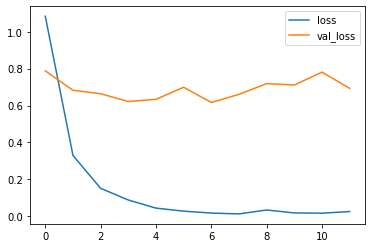

In [32]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

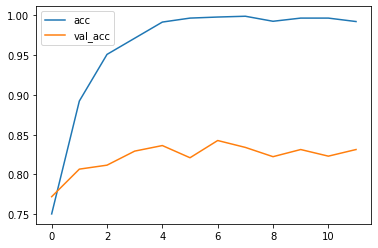

In [33]:
### Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [34]:
# Final evaluation of the model
scores = model.evaluate(XX, yy, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.13%


# Confusion Matrix

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [36]:
# 30 reference isolates
ORDER = [16, 17, 14, 18, 15, 20, 21, 24, 23, 26, 27, 28, 29, 25, 6, 7, 5, 3, 4,
         9, 10, 2, 8, 11, 22, 19, 12, 13, 0, 1]

STRAINS = {}
STRAINS[0] = "C. albicans"
STRAINS[1] = "C. glabrata"
STRAINS[2] = "K. aerogenes"
STRAINS[3] = "E. coli 1"
STRAINS[4] = "E. coli 2"
STRAINS[5] = "E. faecium"
STRAINS[6] = "E. faecalis 1"
STRAINS[7] = "E. faecalis 2"
STRAINS[8] = "E. cloacae"
STRAINS[9] = "K. pneumoniae 1"
STRAINS[10] = "K. pneumoniae 2"
STRAINS[11] = "P. mirabilis"
STRAINS[12] = "P. aeruginosa 1"
STRAINS[13] = "P. aeruginosa 2"
STRAINS[14] = "MSSA 1"
STRAINS[15] = "MSSA 3"
STRAINS[16] = "MRSA 1 (isogenic)"
STRAINS[17] = "MRSA 2"
STRAINS[18] = "MSSA 2"
STRAINS[19] = "S. enterica"
STRAINS[20] = "S. epidermidis"
STRAINS[21] = "S. lugdunensis"
STRAINS[22] = "S. marcescens"
STRAINS[23] = "S. pneumoniae 2"
STRAINS[24] = "S. pneumoniae 1"
STRAINS[25] = "S. sanguinis"
STRAINS[26] = "Group A Strep."
STRAINS[27] = "Group B Strep."
STRAINS[28] = "Group C Strep."
STRAINS[29] = "Group G Strep."

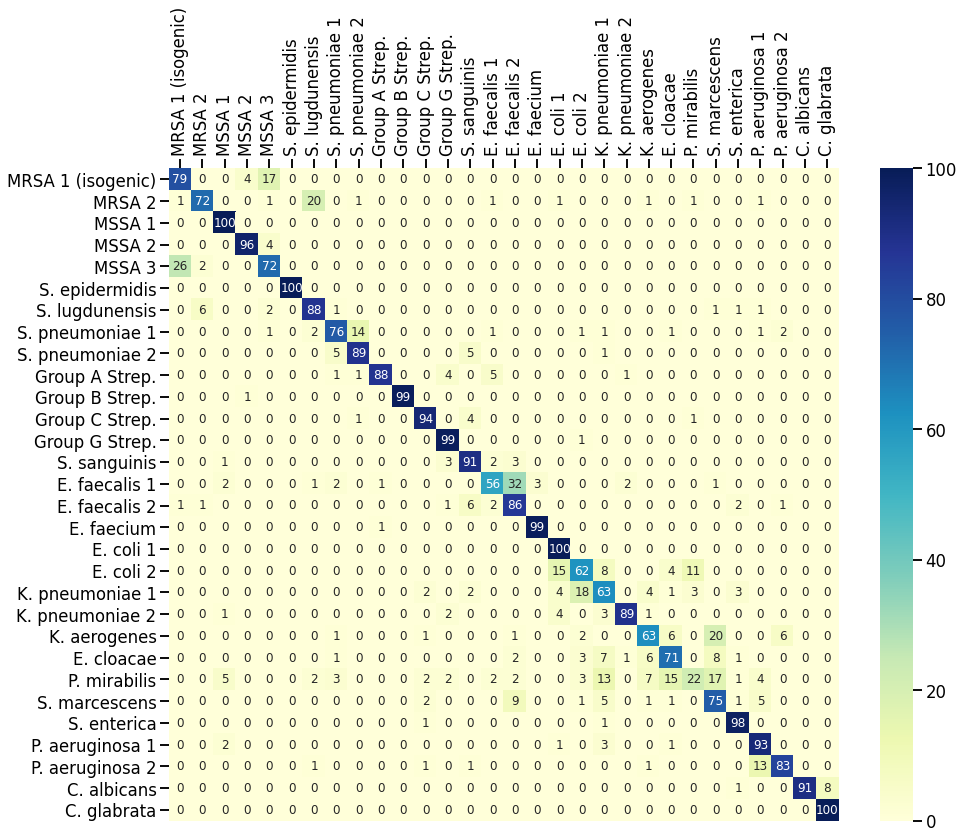

In [37]:
# Plot confusion matrix
p_test = model.predict(X_test).argmax(axis=1)

sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [STRAINS[i] for i in ORDER]
cm = confusion_matrix(y_test, p_test, labels=ORDER)
plt.figure(figsize=(15, 12))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

Misclassified Examples

In [38]:
# Label mapping
labels = '''C_albicans
C_glabrata
K_aerogenes
E_coli_1
E_coli_2
E_faecium
E_faecalis_1
E_faecalis_2
E_cloacae
K_pneumoniae_1
K_pneumoniae_2
P_mirabilis
P_aeruginosa_1
P_aeruginosa_2
MSSA_1
MSSA_3
MRSA_1
MRSA_2
MSSA_2
S_enterica
S_epidermidis
S_lugdenensis
S_marcescens
S_pneumoniae_2
S_pneumoniae_1
S_sanguinis
Group_A_Strep.
Group_B_Strep
Group_C_Strep
Group_G_Strep'''.split()

Total misclassifications: 506
Index of misclassified example: 614


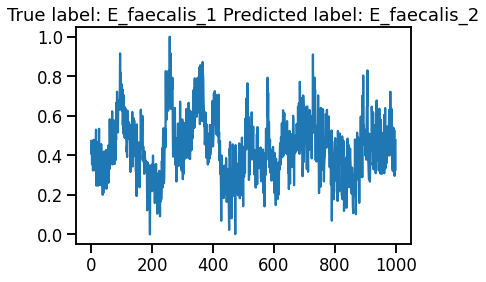

In [41]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
print('Total misclassifications:', len(misclassified_idx))
print('Index of misclassified example:',i)
#print(type(i))
# Changing float64 to int64
new_i = i.astype(int)
y_testnew = y_test.astype(int)
p_testnew = p_test.astype(int)
#print(type(new_i))
plt.plot(X_test[new_i])
plt.title("True label: %s Predicted label: %s" % (labels[y_testnew[new_i]], labels[p_testnew[new_i]]));